Draft to measure emmsion lines. Make model line, convolve model by appropriate lsf, fit to spectrum.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
from astropy.modeling import functional_models

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [18]:
path = '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/'

In [19]:
hdul = fits.open('{}hlsp_muscles_multi_multi_gj15a_broadband_v1_var-res-sed.fits'.format(path))

In [20]:
data = hdul[1].data
inst_list = hdul[2].data
inst_list

FITS_rec([( 65536, 'MOD', 'LYA', 'YOUNG', 'hlsp_muscles_mod_lya_gj15a_young_v1_component-spec.fits'),
          (    16, 'HST', 'STS', 'E140M', 'hlsp_muscles_hst_sts_gj15a_e140m_v1_component-spec.fits'),
          (524288, 'HST', 'STS', 'G230LB', 'hlsp_muscles_hst_sts_gj15a_g230lb_v1_component-spec.fits'),
          (131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj15a_na_v1_component-spec.fits'),
          (   256, 'HST', 'STS', 'G430L', 'hlsp_muscles_hst_sts_gj15a_g430l_v1_component-spec.fits'),
          (131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj15a_na_v1_component-spec.fits'),
          (  8192, 'CXO', 'ACS', 'NA', 'hlsp_muscles_cxo_acs_gj15a_na_v1_component-spec.fits'),
          ( 32768, 'MOD', 'APC', 'NA', 'hlsp_muscles_mod_apc_gj15a_na_v1_component-spec.fits'),
          ( 16384, 'MOD', 'EUV', 'YOUNG', 'hlsp_muscles_mod_euv_gj15a_young_v1_component-spec.fits')],
         dtype=(numpy.record, [('BITVALUE', '>i8'), ('TELESCOPE', 'S3'), ('INSTRUMENT', 'S3'), ('GRATIN

In [21]:
mask = (data['WAVELENGTH'] > 1160) & (data['WAVELENGTH'] < 2000) & (data['INSTRUMENT'] != 65536)

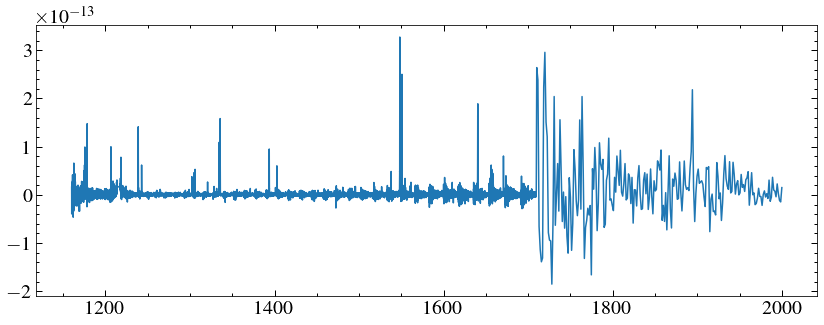

In [22]:
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])

In [23]:
line_list = Table.read('all_linelist.csv')

(1160.0, 1700.0)

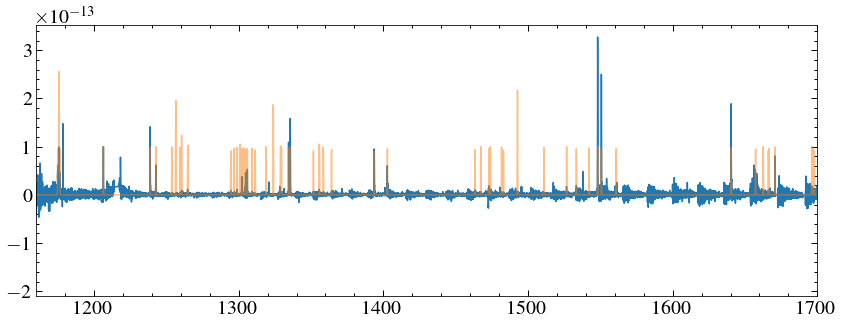

In [24]:
mod1 = models.Const1D(0)
for i in range(len(line_list)):
    amp = 1e-13
#     if line_list['Likelihood to measure'][i] == 'Low':
#         amp = amp/3
#     if line_list['Likelihood to measure'][i] == 'Medium':
#         amp = amp/2
    if line_list['Likelihood to measure'][i] in ['High', 'Medium']:
#     mod1 = mod1+ functional_models.Voigt1D(x_0=line_list['Wavelength'][i], amplitude_L=amp, fwhm_G=0.05, fwhm_L=0.05)
        mod1 = mod1 + models.Gaussian1D(amplitude=amp, mean = line_list['Wavelength'][i], stddev=0.1)


mw = np.arange(900, 1700, 0.1)
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])
plt.plot(mw, mod1(mw), alpha=0.5)
plt.xlim(1160, 1700)


-5.630908556751834 km / s 0.0 km / s


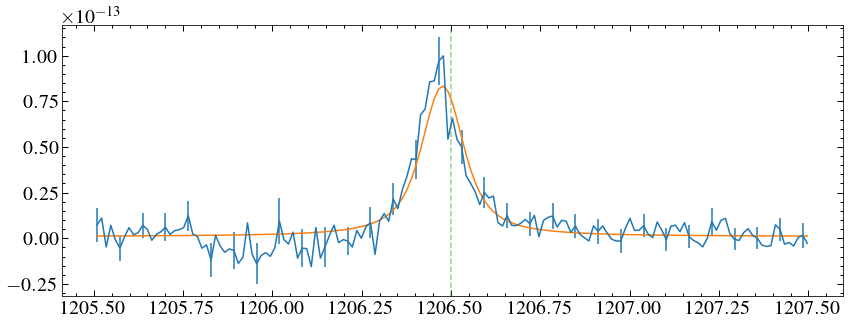

-7.65283640166608 km / s 0.0 km / s
-11.369558835408277 km / s 0.0 km / s


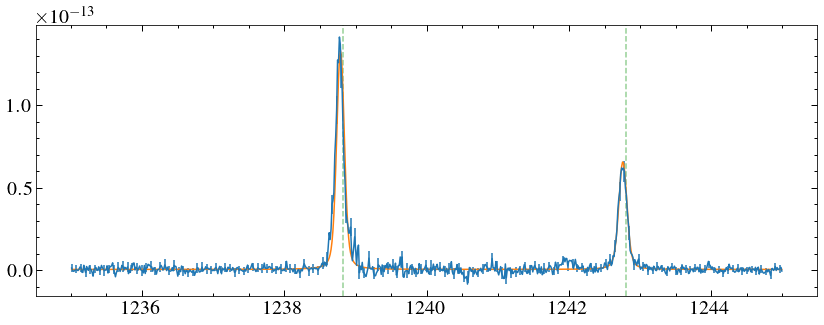

-14.07407581840951 km / s 0.0 km / s
-7.11077372957526 km / s 0.0 km / s


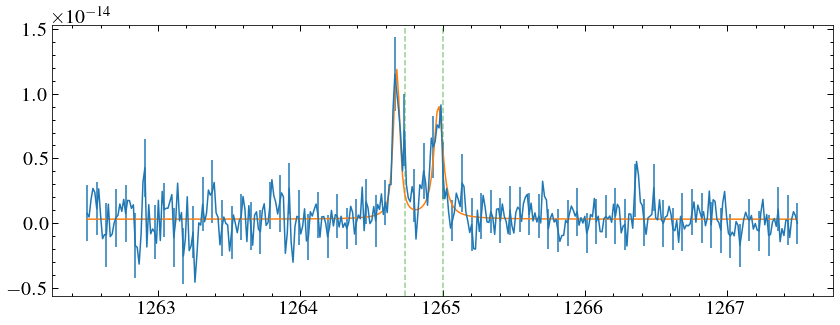

-10.575997387564556 km / s 1.9687278474123104e-08 km / s
-4.154449303053628 km / s 5.7747131521068695e-09 km / s


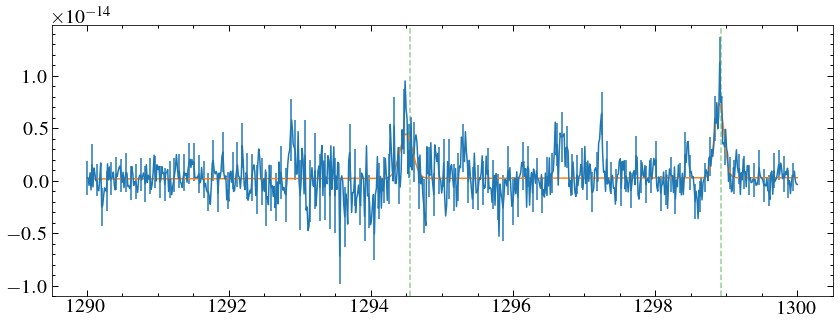

-30.741721074629375 km / s 0.0 km / s


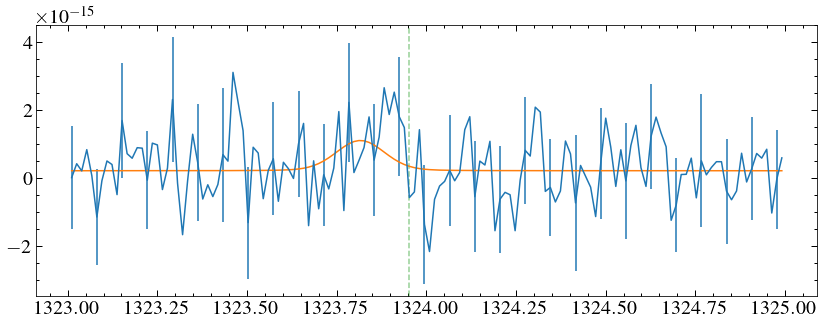

-1.1231852729168255 km / s 0.0 km / s
-9.703064250097787 km / s 0.0 km / s


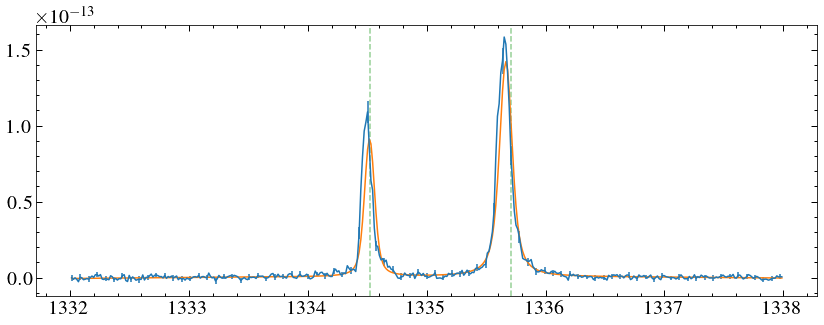

-4.4797671047380545 km / s 0.0 km / s
-2.4388578228550104 km / s 0.0 km / s


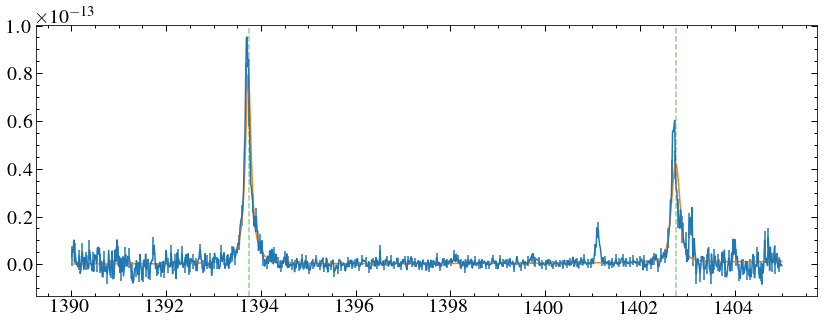

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


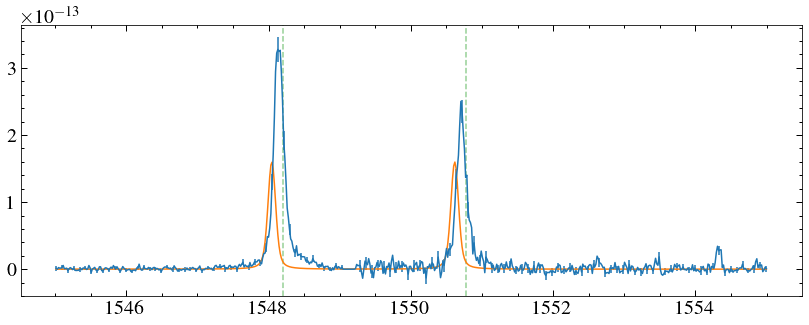

-13.588748682408392 km / s 4.992539714976374e-11 km / s


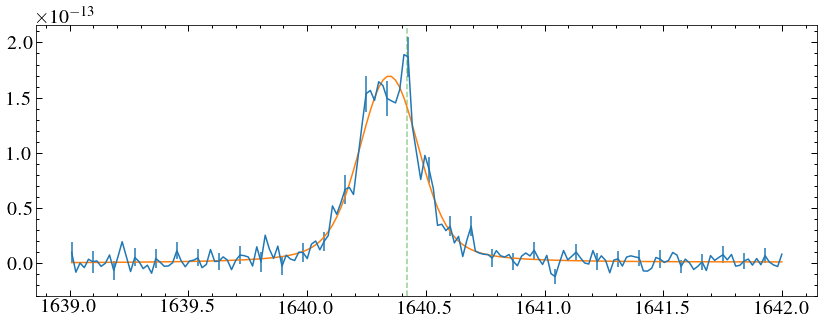

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


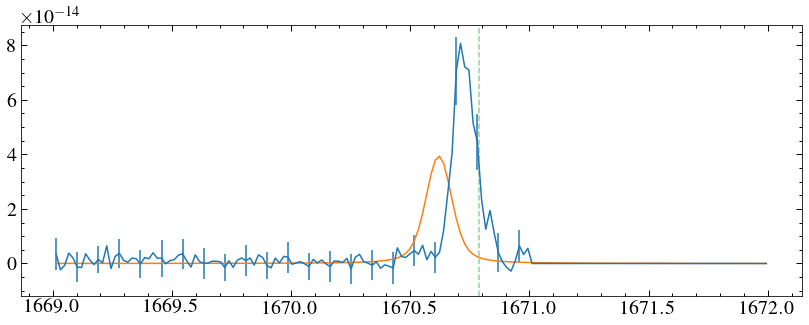

232.59148292242182 km / s 2.5467882650787033e-05 km / s
147.58711602492258 km / s 1.7871755161991132e-05 km / s


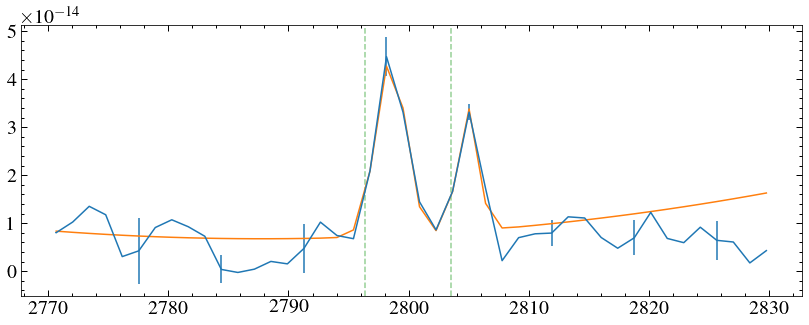

In [25]:
#50 AA chunks?
fitter = fitting.LevMarLSQFitter()
start = 1150
step = 60
w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
# lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']
lines = line_list[(line_list['Likelihood to measure'] == 'High')]['Wavelength']


chunks = [[1205.5, 1207.5], [1235, 1245], [1262.5, 1267.5], [1290, 1300], [1323, 1325], [1332, 1338], [1350, 1352.5], [1390, 1405], 
          [1520, 1540], 
          [1545, 1555], [1639, 1642], [1669, 1672], [2770, 2830]]


dv_guess = -30*u.km/u.s

smooth =7 

dvs = []
dv_es = []

for chunk in chunks:
    start, end = chunk[0], chunk[1]
    mask = (w >= start) & (w <= end)

    lmask = (lines >= start) & (lines <= end)
    if len(lines[lmask]) > 0:
    #         plt.plot(w[mask], f[mask])
        fi, ei = f[mask], e[mask]

    #         mod = models.Const1D(0)
        mod = models.Polynomial1D(2)
        std_guess = 0.5
        if np.median(inst[mask]) in [1, 2, 16]:
                std_guess = 0.1
        if np.median(inst[mask]) in [1, 2]:
                fi = convolve(fi,Box1DKernel(smooth))
                ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
        plt.errorbar(w[mask], fi, yerr =ei, errorevery=5)
    #         print(std_guess)
        for line in lines[lmask]:
            line_guess = dv_guess.to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
#             mod = mod+  models.Gaussian1D(amplitude=np.max(fi), mean = line_guess, stddev=std_guess)
            mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fi), fwhm_G=std_guess, fwhm_L=std_guess*0.5)#, bounds=dict(amplitude_L=[0, 1]))
            plt.axvline(line, ls='--', c='C2', alpha =0.5)
    #             plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)
        gg_fit = fitter(mod, w[mask], fi, weights = 1/ei, maxiter=10000)
#         print(gg_fit)
        if type(fitter.fit_info['param_cov']) == np.ndarray:
        #     print('hooray!')
            fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
            mean_es = fit_e[4:][::4]
        
    #         print(gg_fit)
            for i in range(len(lines[lmask])):
                mean = gg_fit[i+1].x_0
#                 mean = gg_fit[i+1].mean
                mean_e = mean_es[i]
#                 line_e = 
        #             obs_line = gg_fit[i+1].mean*u.AA
        
                dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
                eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
                edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
                dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
                print(dv, dve)
                dvs.append(dv)
                dv_es.append(dve)
        
        
        
        plt.plot(w[mask], gg_fit(w[mask]))
        plt.show()
#     start += step
    

What about just doublets to get the rv?

In [26]:
dvs = np.array([dv.value for dv in dvs])

17.168976980484654 -7.11077372957526 69.9083098640119


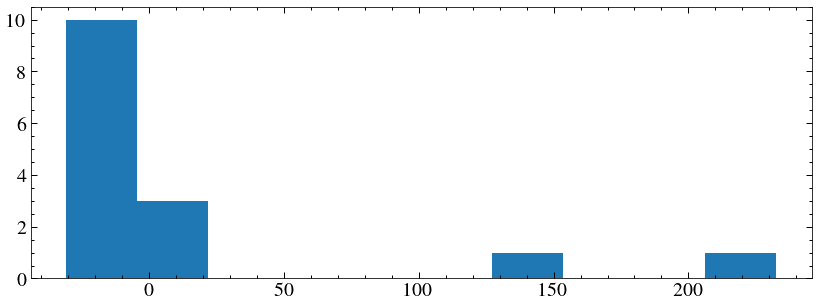

In [27]:
plt.hist(dvs)
print(np.mean(dvs), np.median(dvs), np.std(dvs))

In [28]:
np.mean([1298.892,
1298.944])

1298.9180000000001

In [29]:
dvs

array([ -5.63090856,  -7.6528364 , -11.36955884, -14.07407582,
        -7.11077373, -10.57599739,  -4.1544493 , -30.74172107,
        -1.12318527,  -9.70306425,  -4.4797671 ,  -2.43885782,
       -13.58874868, 232.59148292, 147.58711602])

In [30]:
specs = glob.glob('{}*var*'.format(path))
specs

['/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj649_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj1132_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj15a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj163_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj674_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj676a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj699_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj729_broadb

In [31]:
# lines = line_list[(line_list['Likelihood to measure'] == 'High')]['Wavelength']


# chunks = [[1170, 1180], [1205.5, 1207.5], [1235, 1245], [1262.5, 1267.5], [1290, 1310], [1323, 1325], [1332, 1338], [1390, 1405],  
#           [1545, 1555], [1637, 1644], [1645, 1665], [1668, 1673], [2770, 2830]]

# for spec in specs:
#     print(spec)
#     plt.figure(figsize = (14, 5*len(chunks)))
#     data = fits.getdata(spec, 1)
#     star = fits.getheader(spec)['TARGNAME']
#     print(star)
#     #50 AA chunks?
#     w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
#     # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']



#     dv_guess = 0*u.km/u.s

#     smooth =7 

#     dvs = []
#     dv_es = []

#     for i, chunk in enumerate(chunks):
#         plt.subplot(len(chunks), 1 , i+1)
#         start, end = chunk[0], chunk[1]
#         mask = (w >= start) & (w <= end)

#         lmask = (lines >= start) & (lines <= end)
#         if len(lines[lmask]) > 0 and len(w[mask]) >0:
#         #         plt.plot(w[mask], f[mask])
#             fi, ei = f[mask], e[mask]

#         #         mod = models.Const1D(0)
#             mod = models.Polynomial1D(2)
#             std_guess = 0.5
#             if np.median(inst[mask]) in [1, 2, 16]:
#                 std_guess = 0.1
#             if np.median(inst[mask]) in [1, 2]:
#                 fi = convolve(fi,Box1DKernel(smooth))
#                 ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5

#             plt.errorbar(w[mask], fi, yerr =ei, errorevery=5)
#         #         print(std_guess)
#             for line in lines[lmask]:
#                 line_guess = dv_guess.to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
#                 mod = mod+  models.Gaussian1D(amplitude=np.max(fi), mean = line_guess, stddev=std_guess)
# #                 mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fi), fwhm_G=std_guess, fwhm_L=std_guess*0.5)#, bounds=dict(amplitude_L=[0, 1]))
#                 plt.axvline(line, ls='--', c='C2', alpha =0.5)
#         #             plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)
#             gg_fit = fitter(mod, w[mask], fi, weights = 1/ei, maxiter=10000)
#     #         print(gg_fit)
#             if type(fitter.fit_info['param_cov']) == np.ndarray:
#             #     print('hooray!')
#                 fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#                 mean_es = fit_e[3:][1::3]

#         #         print(gg_fit)
#                 for i in range(len(lines[lmask])):
# #                     mean = gg_fit[i+1].x_0
#                     mean = gg_fit[i+1].mean
#                     mean_e = mean_es[i]
#     #                 line_e = 
#             #             obs_line = gg_fit[i+1].mean*u.AA

#                     dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
#                     eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
#                     edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
#                     dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
# #                     print(dv, dve)
#                     dvs.append(dv)
#                     dv_es.append(dve)



#             plt.plot(w[mask], gg_fit(w[mask]))
#     plt.savefig('line_plots/{}_lines.pdf'.format(star), dpi=150)
#     plt.show()
#     #     start += step


Measuring clean doublets that are detected in all stars to get velocities

GJ649
1238.821 -1.6979089153965399 km / s 0.3257124905433769 km / s
1242.804 -1.6924673725286805 km / s 0.4442153064876103 km / s
1334.524 -2.93152955326465 km / s 0.28952429267976476 km / s
1335.709 -2.928928790270668 km / s 0.3644750472492755 km / s
1393.755 89.99907052895954 km / s 12.704926224146668 km / s
1402.77 89.42068517648809 km / s 16.124760136842625 km / s


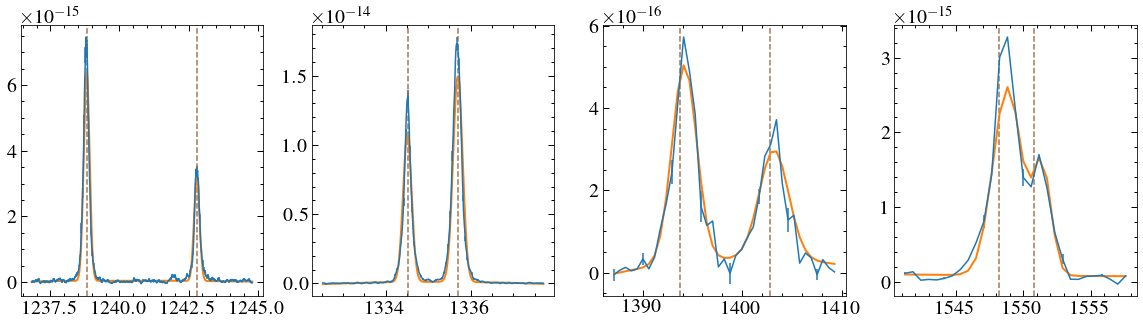

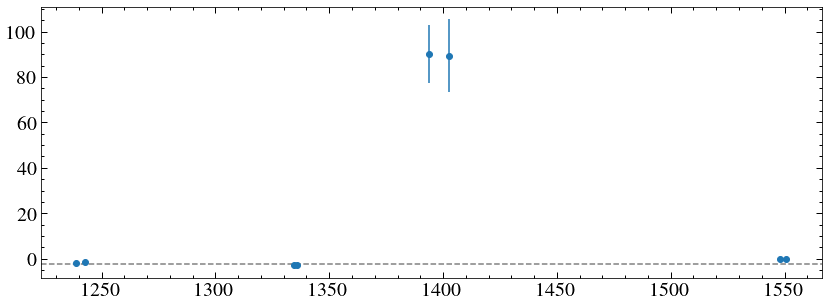

GJ1132
1238.821 37.443465131964054 km / s 1.2274832092549275 km / s
1242.804 37.32346445476203 km / s 1.306570079843457 km / s
1334.524 44.912256066841174 km / s 1.0259481244080426 km / s
1335.709 44.872411292655855 km / s 0.9784925725277098 km / s
1393.755 49.68560374199048 km / s 1.160169082592354 km / s
1402.77 49.36629571733863 km / s 1.0781264712718581 km / s
1548.201 35.89814844678167 km / s 1.1425079959286428 km / s
1550.772 35.83863348280118 km / s 1.7007340621069247 km / s


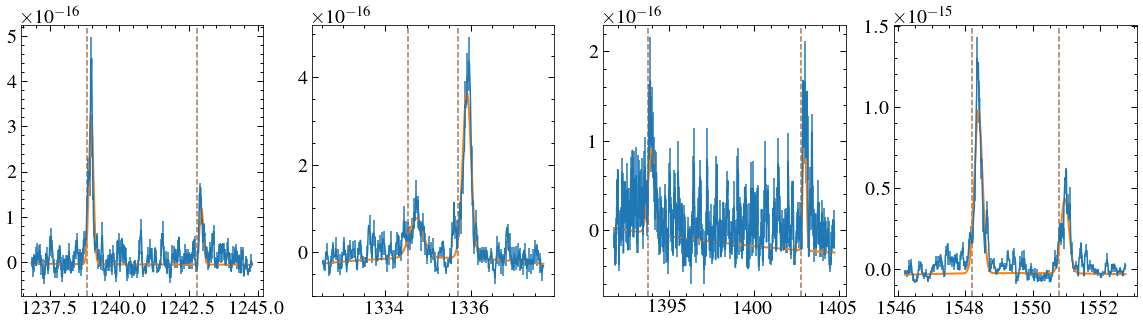

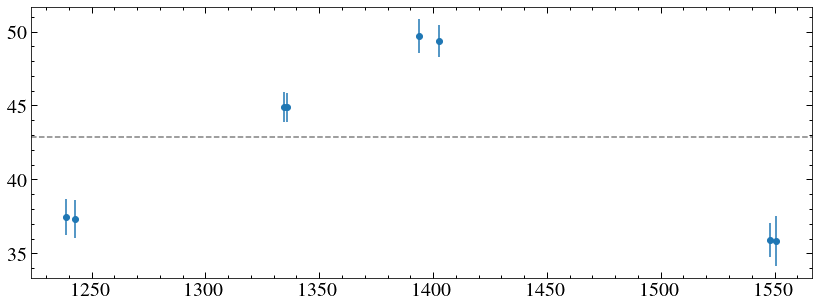

GJ15A
1238.821 -8.044451964166532 km / s 0.4295258080993456 km / s
1242.804 -8.018670704877103 km / s 0.5051139235109452 km / s
1334.524 -4.505444951397365 km / s 0.5246544121017673 km / s
1335.709 -4.501447859016567 km / s 0.5824436029747162 km / s
1393.755 -3.5302285299070375 km / s 0.7804333760257032 km / s
1402.77 -3.507541268132525 km / s 0.9764752929350546 km / s


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


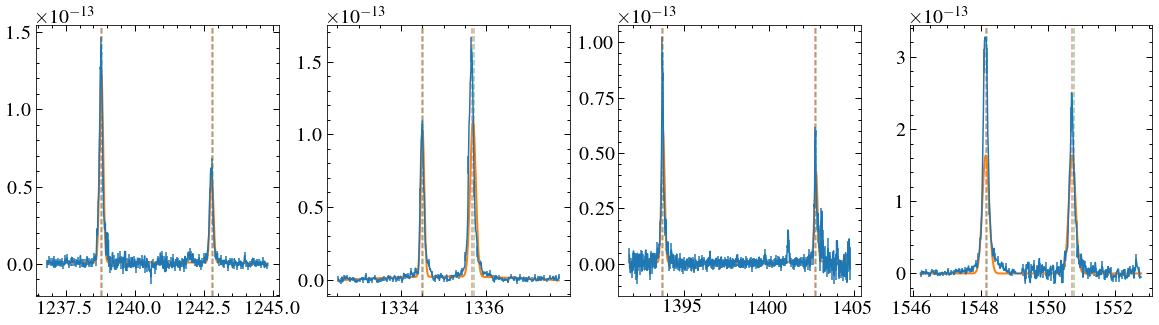

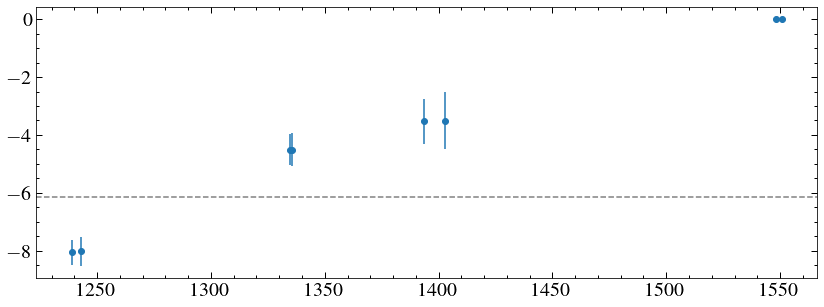

GJ163
1238.821 46.1467499862126 km / s 0.7563408760963313 km / s
1242.804 45.99885658938408 km / s 1.5026759184665828 km / s
1334.524 57.389412094010005 km / s 0.48136972947899537 km / s
1335.709 57.33849797020226 km / s 0.5909310819514708 km / s
1393.755 57.627226165628095 km / s 1.4014105913478438 km / s
1402.77 57.25688074631522 km / s 2.7791873677612777 km / s
1548.201 -31.15444459172549 km / s 0.7153085947867215 km / s
1550.772 -31.10279413824537 km / s 1.1740933763947847 km / s


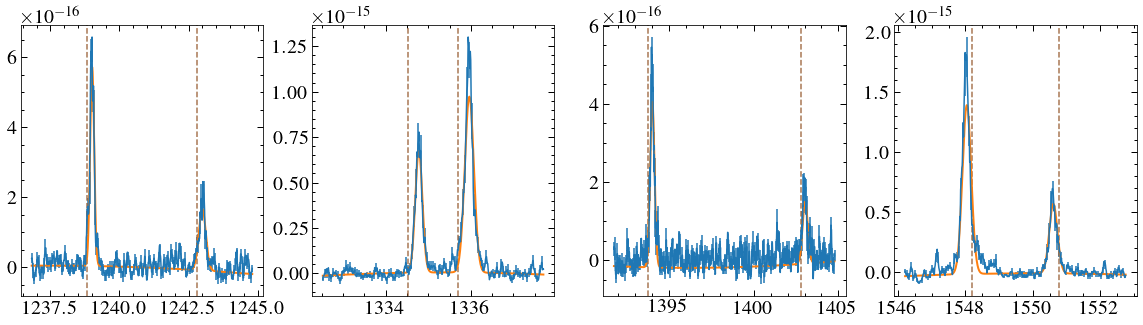

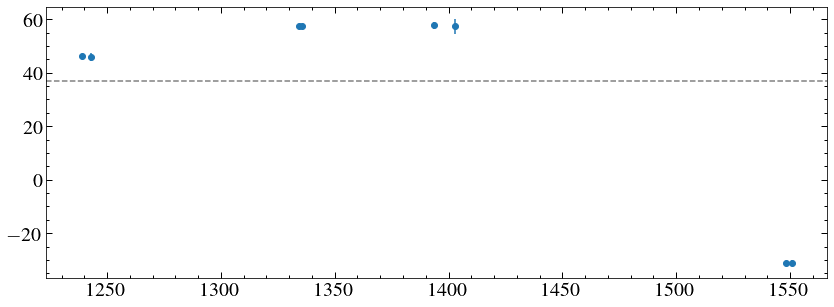

GJ674
1238.821 -4.559302755540308 km / s 0.6826956483763849 km / s
1242.804 -4.544690875586616 km / s 0.9591063140422211 km / s
1334.524 -7.884205009559089 km / s 0.6840906694495286 km / s
1335.709 -7.8772103850307325 km / s 0.9644033069546412 km / s
1393.755 -55.18349108403306 km / s 19.451339726324566 km / s
1402.77 -54.82885049995771 km / s 19.231087626657654 km / s


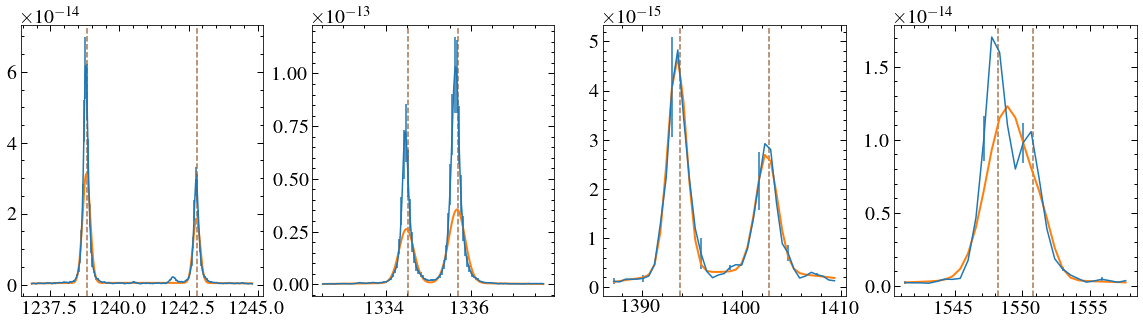

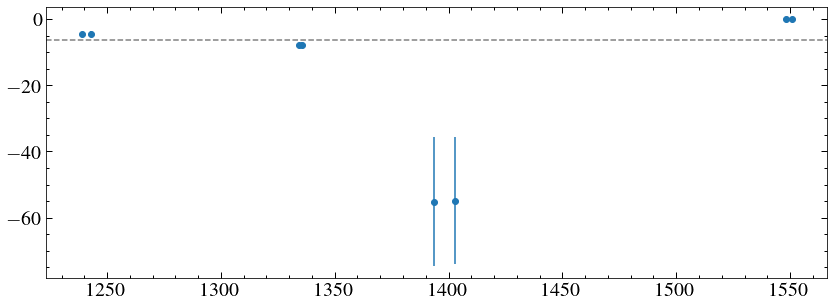

GJ676A
1238.821 -43.79737116322696 km / s 0.28369125297138353 km / s
1242.804 -43.65700717232837 km / s 0.3419327196732844 km / s
1334.524 -45.10569890457635 km / s 0.3091069566962794 km / s
1335.709 -45.06568251387271 km / s 0.3369650799667063 km / s
1393.755 -52.91657155173373 km / s 10.113792626852732 km / s
1402.77 -52.576499485374676 km / s 20.04857353265954 km / s


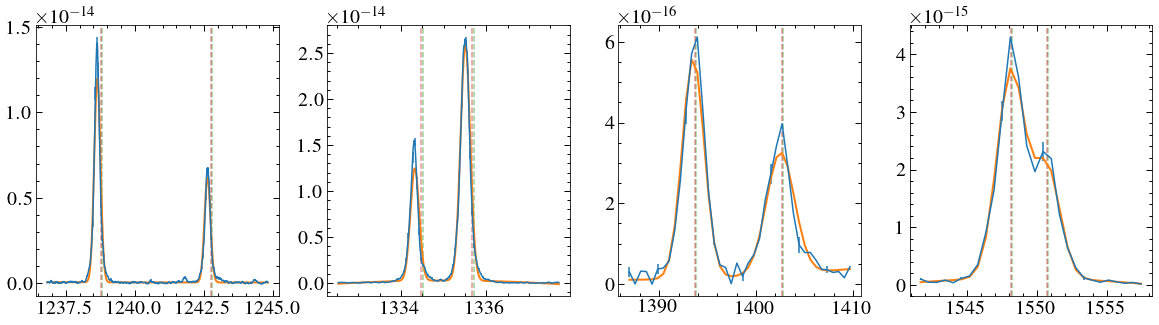

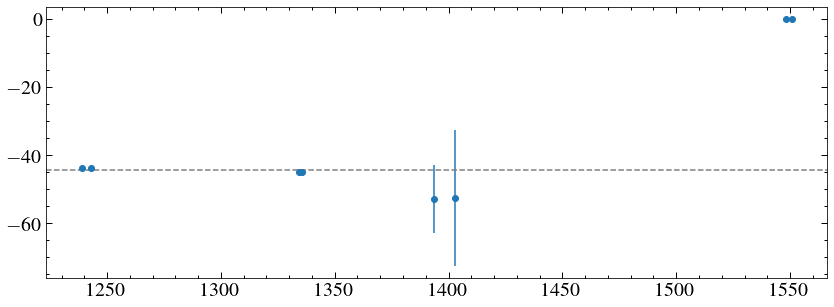

GJ699
1238.821 -131.0467045085031 km / s 0.4304381008017657 km / s
1242.804 -130.6267195196832 km / s 0.6381670815532487 km / s
1334.524 -118.71265554292944 km / s 0.41005432092287464 km / s
1335.709 -118.60733732106259 km / s 0.5869268738760027 km / s
1393.755 -96.18938907484755 km / s 36.15970384762484 km / s
1402.77 -95.57122120518957 km / s 70.17414857202672 km / s


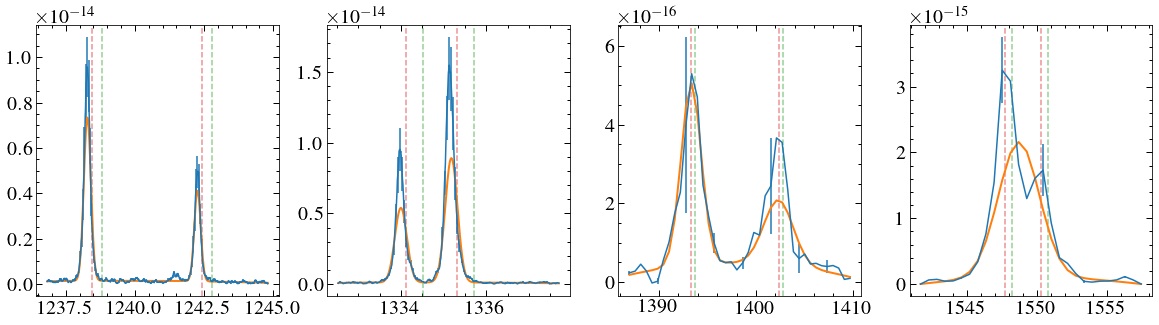

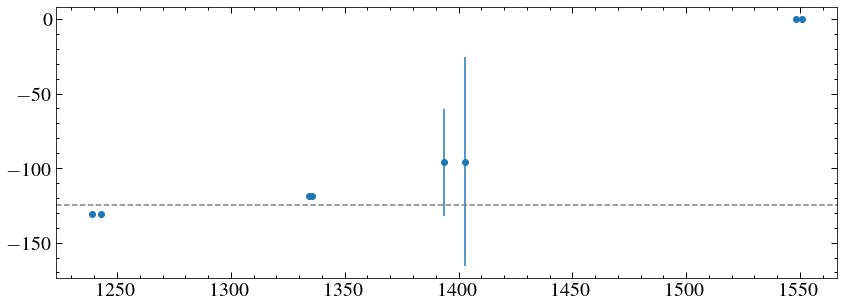

GJ729
1238.821 2.7279703465056944 km / s 3.411143910337316 km / s
1242.804 2.7192276116138814 km / s 5.290048636450248 km / s
1334.524 12.533342652748294 km / s 0.7911452881153389 km / s
1335.709 12.522223456135304 km / s 0.44683039832545024 km / s
1393.755 15.963855172483559 km / s 2.3174222166526706 km / s
1402.77 15.861262335147735 km / s 3.2548325873399735 km / s
1548.201 14.796710461672648 km / s 1.0388303511129697 km / s
1550.772 14.772179232958546 km / s 2.11715413031878 km / s


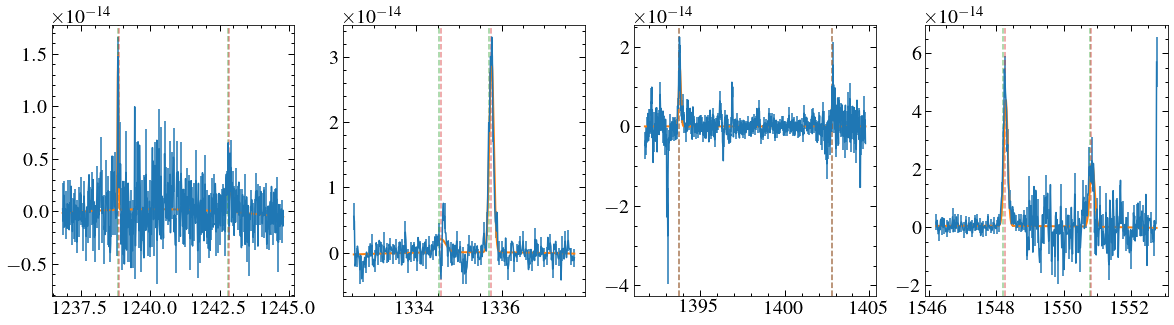

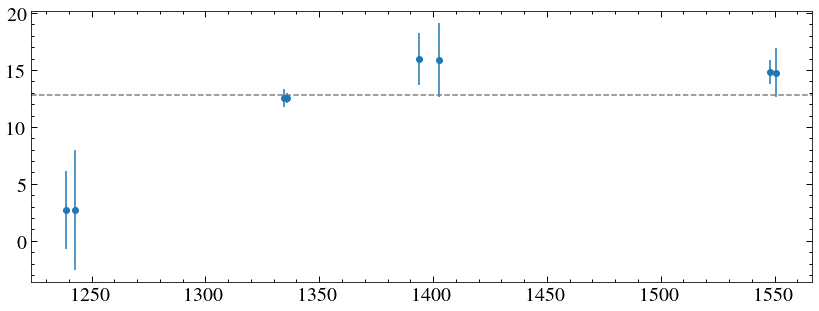

GJ849
1238.821 -24.073155596952297 km / s 0.3122444557573072 km / s
1242.804 -23.996004751982163 km / s 0.4684681429069695 km / s
1334.524 -18.53021773550138 km / s 0.30034935800915896 km / s
1335.709 -18.51377829545001 km / s 0.3064269867889351 km / s
1393.755 -13.890230266596163 km / s 0.6051063626582192 km / s
1402.77 -13.800963725477589 km / s 0.9416470162401982 km / s
1548.201 -29.133524088928024 km / s 0.42653706980803285 km / s
1550.772 -29.085224087105882 km / s 0.635720065602353 km / s


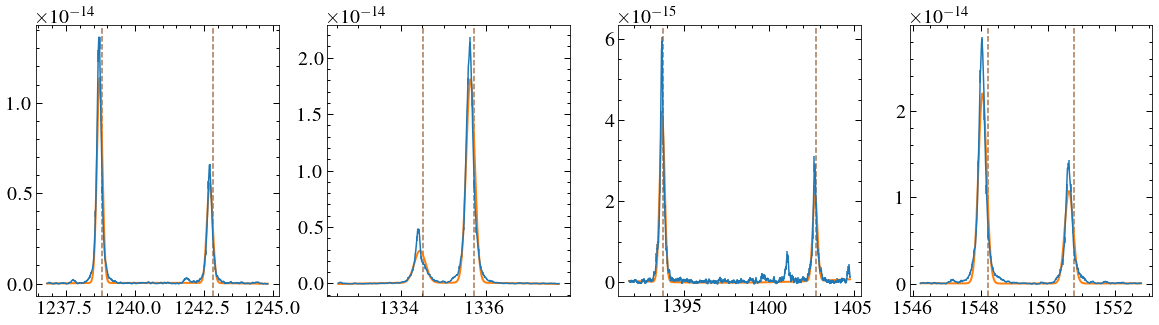

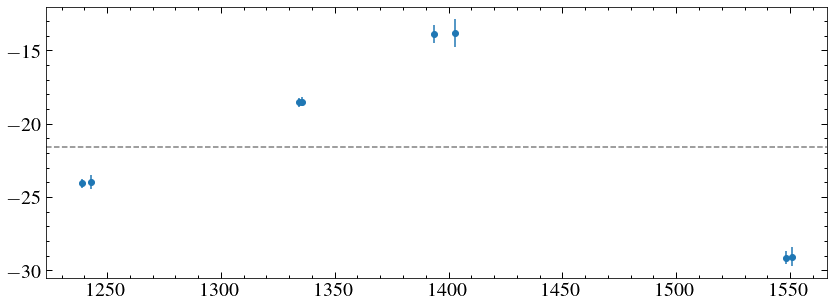

L-980-5
1238.821 -0.5713429299605015 km / s 0.9686600706593672 km / s
1242.804 -0.5695118617662253 km / s 1.337604627901618 km / s
1334.524 19.74682426735451 km / s 0.6238009093010994 km / s
1335.709 19.72930549142219 km / s 0.7664053974161167 km / s
1393.755 27.411674531981188 km / s 1.2243008532044612 km / s
1402.77 27.235511478934086 km / s 1.136157390869334 km / s
1548.201 15.713430364158734 km / s 0.8210451655438584 km / s
1550.772 15.687379320292003 km / s 1.145364668012653 km / s


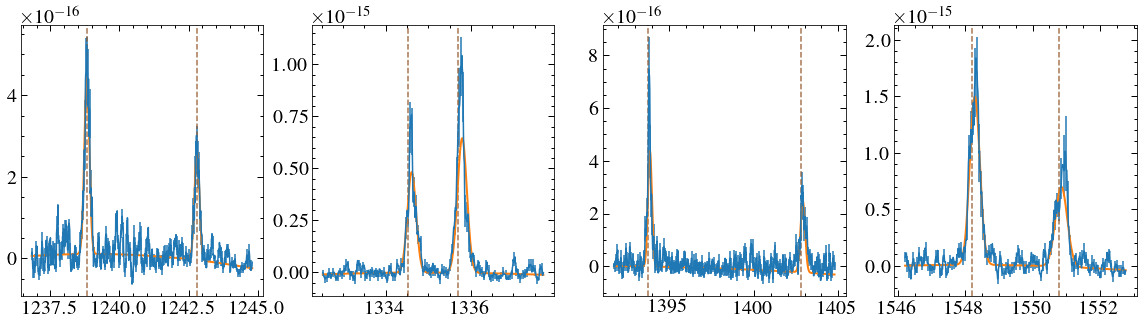

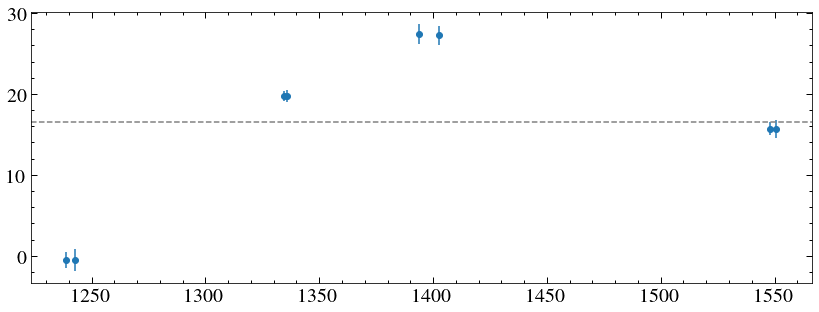

LHS-2686
1238.821 8.168387369776909 km / s 0.35243515288056404 km / s
1242.804 8.142208916102003 km / s 0.4580895149386097 km / s
1334.524 6.38836890355093 km / s 0.47945387994262045 km / s
1335.709 6.382701338911885 km / s 0.5841648518524978 km / s
1393.755 -123.91990932159669 km / s 32.96498914406953 km / s
1402.77 -123.1235293145091 km / s 28.75804028550506 km / s


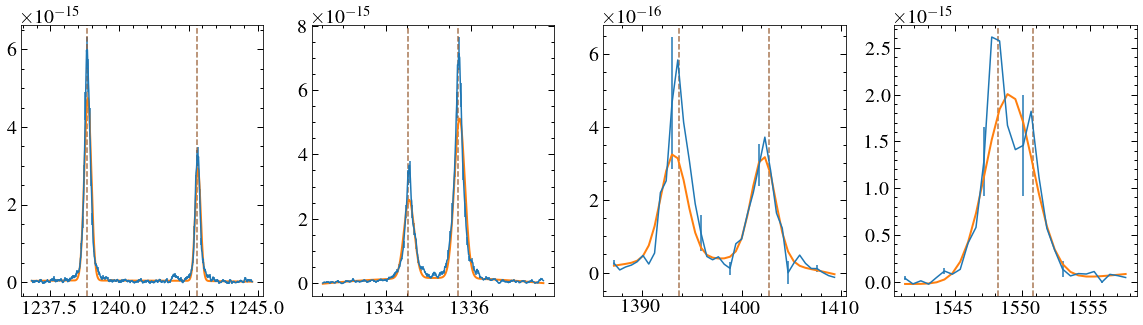

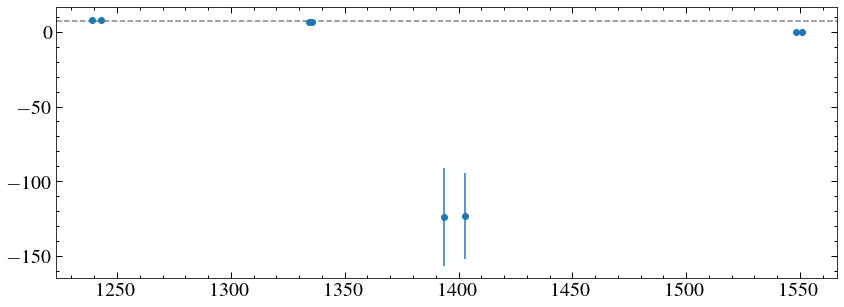

2MASS-J23062928-0502285
1238.821 -166.4828289932512 km / s 23.977956270704297 km / s
1242.804 -165.9492765522571 km / s 75.73979210530376 km / s
1334.524 -63.626356663029505 km / s 1.7643509743272787 km / s
1335.709 -63.56990931358064 km / s 1.7797282053980616 km / s
1393.755 -53.19017304617501 km / s 6.032264491098328 km / s
1402.77 -52.84834266055855 km / s 6.98506884649731 km / s
1548.201 -58.27314978477563 km / s 2.6342271941945086 km / s
1550.772 -58.176539665365055 km / s 3.0750552773985547 km / s


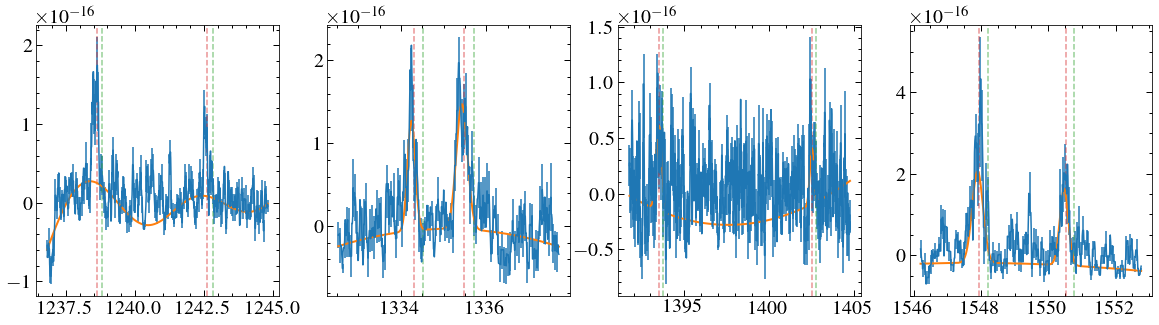

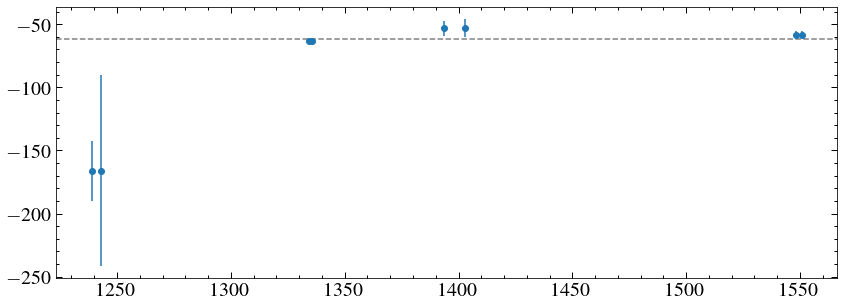

In [42]:
stars = []
final_dv = []
fitter = fitting.LevMarLSQFitter()


doublets = np.array([[1238.821, 1242.804],[1334.524,1335.709],[1393.755,1402.77],[1548.201,1550.772]])
all_lines = doublets.flatten()
names = ['N\,v', 'C\,II', 'Si\,IV', 'C\,IV']

dv_guess = np.array([0, 0, -10, 0, 0, -10, -90, 10, 0, 0, 0, -50])*u.km/u.s

for j, spec in enumerate(specs):
#     print(spec)
    plt.figure(figsize = (5*len(doublets), 5))
    data = fits.getdata(spec, 1)
    star = fits.getheader(spec)['TARGNAME']
    print(star)
    stars.append(star)
    w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
    # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

    smooth =7 

    dvs = []
    dv_es = []

    for i, lines in enumerate(doublets):
        plt.subplot(1, len(doublets) , i+1)
#         start, end = lines[0]-5, lines[1]+5
        mask = (w >= lines[0]-7) & (w <= lines[1]+7)
        if np.median(inst[mask]) in [1, 2, 16]:
            mask = (w >= lines[0]-2) & (w <= lines[1]+2)
        wi, fi, ei = w[mask], f[mask], e[mask]
        mod = models.Polynomial1D(2)
        std_guess = 0.5
        if np.median(inst[mask]) in [1, 2, 16]:
            std_guess = 0.1
        if np.median(inst[mask]) in [1, 2]:
            fi = convolve(fi,Box1DKernel(smooth))
            ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
        plt.errorbar(w[mask], fi, yerr =ei, errorevery=5)
    #         print(std_guess)
        for line in lines:
            line_guess = dv_guess[j].to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
            mod = mod+  models.Gaussian1D(amplitude=np.max(fi)/2, mean = line_guess, stddev=std_guess)
#                 mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fi), fwhm_G=std_guess, fwhm_L=std_guess*0.5)#, bounds=dict(amplitude_L=[0, 1]))
            plt.axvline(line, ls='--', c='C2', alpha =0.5)
            plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)
    
        def tiedfunc0(mod):
            mean = mod.mean_1.value+np.diff(lines)
            return mean
        
        mod.mean_2.tied=tiedfunc0
        
        gg_fit = fitter(mod, w[mask], fi, weights = 1/ei, maxiter=10000)
#         print(gg_fit)

        if i == 3 and  np.median(inst[mask]) not in [1, 2, 16]:
            dvs.append(0)
            dvs.append(0)
            dv_es.append(0)
            dv_es.append(0)
        elif type(fitter.fit_info['param_cov']) == np.ndarray:
        #     print('hooray!')
            fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
            mean_es = fit_e[3:][1::3]

    #         print(gg_fit)
            for i in range(len(lines)):
#                     mean = gg_fit[i+1].x_0
                mean = gg_fit[i+1].mean
                mean_e = mean_es[i]
#                 line_e = 
        #             obs_line = gg_fit[i+1].mean*u.AA

                dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[i]*u.AA))
                eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[i]*u.AA))
                edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[i]*u.AA))
                dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
                print(lines[i], dv, dve)
                dvs.append(dv.value)
                dv_es.append(dve.value)
        else:
            dvs.append(0)
            dvs.append(0)
            dv_es.append(0)
            dv_es.append(0)
   
            
    
        plt.plot(wi, gg_fit(wi), lw=2)
#     plt.savefig('line_plots/{}_lines.pdf'.format(star), dpi=150)
    plt.show()
    dvs, dv_es = np.array(dvs), np.array(dv_es)
    dv_av = np.average(dvs[dvs !=0], weights = 1/dv_es[dvs !=0]**2)
    final_dv.append(dv_av)
    plt.errorbar(all_lines, dvs, yerr =dv_es, marker='o', ls='none')
    plt.axhline(dv_av, ls='--', c='0.5')
    plt.show()
    
    #     start += step


In [43]:
for s, v in zip(stars, final_dv):
    print(s, v)

GJ649 -2.3762525735196323
GJ1132 42.880335253647566
GJ15A -6.133126961200428
GJ163 36.7424115403314
GJ674 -6.253242077258207
GJ676A -44.38781746117124
GJ699 -124.42973804442362
GJ729 12.81534450898705
GJ849 -21.58893160354172
L-980-5 16.491394610720274
LHS-2686 7.502619644939549
2MASS-J23062928-0502285 -61.83649803157711
